In [41]:
!pip install torchmetrics
!pip install torch-fidelity


In [ ]:

import os

from google.colab import drive
drive.mount('/content/drive')

model_dir = "/content/drive/MyDrive/vae_gan_models"
vae_results_dir = os.path.join(model_dir, "results/vae")
gan_results_dir = os.path.join(model_dir, "results/gan")
logs_dir = os.path.join(model_dir, "logs")

os.makedirs(vae_results_dir, exist_ok=True)
os.makedirs(gan_results_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)


Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict
import json


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


#CAN RUN THIS

class Config:
 
    dataset = "CIFAR10"
    image_size = 32
    num_channels = 3
    num_classes = 10

    batch_size = 128
    num_workers = 4
    num_epochs = 70
    learning_rate = 2e-4
    beta1 = 0.5
    beta2 = 0.999

    
    vae_latent_dim = 128
    vae_beta = 1.0  
    gan_latent_dim = 100
    gan_feature_dim = 64


    log_interval = 100
    sample_interval = 500
    save_interval = 10

config = Config()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0
)


class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

       
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),  
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 1, 0), 
            nn.LeakyReLU(0.2)
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 256)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),  
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, 1, 1)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_dim=64, num_channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_dim * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim * 2, feature_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim, num_channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        input = input.view(-1, self.latent_dim, 1, 1)
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, feature_dim=64, num_channels=3):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(num_channels, feature_dim, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim, feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 4, feature_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

def train_vae(model, optimizer, train_loader, epoch, config):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, config.vae_beta)

        loss.backward()
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()

        optimizer.step()

        if batch_idx % config.log_interval == 0:
            print(f'VAE Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

            if batch_idx % config.sample_interval == 0:
                with torch.no_grad():
                    sample = torch.randn(64, config.vae_latent_dim).to(device)
                    sample = model.decode(sample).cpu()
                    save_image(sample, os.path.join(vae_results_dir, f'sample_epoch_{epoch}_batch_{batch_idx}.png'), nrow=8, normalize=True)



    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = recon_loss_total / len(train_loader.dataset)
    avg_kl_loss = kl_loss_total / len(train_loader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

def train_gan(generator, discriminator, g_optimizer, d_optimizer, train_loader, epoch, config):
    generator.train()
    discriminator.train()

    g_losses = []
    d_losses = []
    real_scores = []
    fake_scores = []

    for batch_idx, (data, _) in enumerate(train_loader):
        real_data = data.to(device)
        batch_size = real_data.size(0)

        real_label = torch.ones(batch_size, 1, device=device)
        fake_label = torch.zeros(batch_size, 1, device=device)

        d_optimizer.zero_grad()

        output_real = discriminator(real_data)
        d_loss_real = F.binary_cross_entropy(output_real, real_label)

        noise = torch.randn(batch_size, config.gan_latent_dim, device=device)
        fake_data = generator(noise)
        output_fake = discriminator(fake_data.detach())
        d_loss_fake = F.binary_cross_entropy(output_fake, fake_label)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()

        output_fake = discriminator(fake_data)
        g_loss = F.binary_cross_entropy(output_fake, real_label)

        g_loss.backward()
        g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        real_scores.append(output_real.mean().item())
        fake_scores.append(output_fake.mean().item())

        if batch_idx % config.log_interval == 0:
            print(f'GAN Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'D Loss: {d_loss.item():.6f}\tG Loss: {g_loss.item():.6f}\t'
                  f'D(x): {output_real.mean().item():.6f}\tD(G(z)): {output_fake.mean().item():.6f}')

            if batch_idx % config.sample_interval == 0:
                with torch.no_grad():
                    sample = torch.randn(64, config.gan_latent_dim).to(device)
                    sample = generator(sample).cpu()
                    save_image(sample, os.path.join(gan_results_dir, f'sample_epoch_{epoch}_batch_{batch_idx}.png'), nrow=8, normalize=True)




    avg_d_loss = np.mean(d_losses)
    avg_g_loss = np.mean(g_losses)
    avg_real_score = np.mean(real_scores)
    avg_fake_score = np.mean(fake_scores)

    return avg_d_loss, avg_g_loss, avg_real_score, avg_fake_score

def evaluate_vae(model, test_loader, beta=1.0):
    """
    Evaluate VAE on test_loader, computing average total loss, reconstruction loss, and KL loss.
    """
    model.eval()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            batch_size = data.size(0)
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_recon = total_recon / total_samples
    avg_kl = total_kl / total_samples

    print(f'====> VAE Test set loss: {avg_loss:.4f}, '
          f'Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}')

    return avg_loss, avg_recon, avg_kl









def preprocess_for_metrics(images):
    """
    Convert images from [-1,1] float32 to [0,255] uint8
    Expected input: images in [-1,1], shape [B, C, H, W]
    """
    images = (images + 1) / 2 
    images = images.clamp(0.0, 1.0)
    images = (images * 255).byte() 
    return images

def calculate_fid_score(real_images, generated_images):
    """
    Computes FID score between real_images and generated_images.
    Inputs should be torch tensors on the same device.
    """
    fid_metric = FrechetInceptionDistance(feature=2048, normalize=False).to(device)

    with torch.no_grad():
        for imgs,_ in test_loader:
            imgs = imgs.to(device)
            fake_imgs = generator(torch.randn(imgs.size(0), config.gan_latent_dim, device=device))
            fid_metric.update(preprocess_for_metrics(imgs), real=True)
            fid_metric.update(preprocess_for_metrics(fake_imgs), real=False)

    fid_score = fid_metric.compute().item()
    print("FID Score:", fid_score)
    return fid_score.item()

def calculate_inception_score(generated_images, splits=10):
    """
    Computes Inception Score for generated images.
    """
    inception_metric = InceptionScore(normalize=False).to(device)

    generated_images = preprocess_for_metrics(generated_images).to(device)

    inception_metric.update(generated_images)
    score, _ = inception_metric.compute()
    print("Inception Score:", score.item())
    return score.item()

def evaluate_gan(generator, test_loader, device=device):
    """
    Evaluates GAN using FID and Inception Score incrementally batch by batch.
    """
    generator.eval()
    all_real_images = []
    all_fake_images = []

    with torch.no_grad():
        for real_images, _ in test_loader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            noise = torch.randn(batch_size, config.gan_latent_dim, device=device)
            fake_images = generator(noise)

            all_real_images.append(real_images)
            all_fake_images.append(fake_images)

    all_real_images = torch.cat(all_real_images, dim=0)
    all_fake_images = torch.cat(all_fake_images, dim=0)

    fid_score = calculate_fid_score(all_real_images, all_fake_images)
    inception_score = calculate_inception_score(all_fake_images)

    return fid_score, inception_score






Using device: cpu


In [ ]:

#DO NOT RUN THIS, THIS THE TRAINING LOOP
vae = VAE(latent_dim=config.vae_latent_dim).to(device)
generator = Generator(
    latent_dim=config.gan_latent_dim,
    feature_dim=config.gan_feature_dim,
    num_channels=config.num_channels
).to(device)
discriminator = Discriminator(
    feature_dim=config.gan_feature_dim,
    num_channels=config.num_channels
).to(device)

vae_optimizer = optim.Adam(vae.parameters(), lr=config.learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=config.learning_rate, betas=(config.beta1, config.beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=config.learning_rate, betas=(config.beta1, config.beta2))

history = {
    'vae': {'train_loss': [], 'recon_loss': [], 'kl_loss': [], 'test_loss': []},
    'gan': {'d_loss': [], 'g_loss': [], 'real_score': [], 'fake_score': []}
}

print("Starting training...")

for epoch in range(1, config.num_epochs + 1):
    start_time = time.time()

    vae_train_loss, vae_recon_loss, vae_kl_loss = train_vae(
        vae, vae_optimizer, train_loader, epoch, config
    )
    history['vae']['train_loss'].append(vae_train_loss)
    history['vae']['recon_loss'].append(vae_recon_loss)
    history['vae']['kl_loss'].append(vae_kl_loss)

    gan_d_loss, gan_g_loss, gan_real_score, gan_fake_score = train_gan(
        generator, discriminator, g_optimizer, d_optimizer, train_loader, epoch, config
    )
    history['gan']['d_loss'].append(gan_d_loss)
    history['gan']['g_loss'].append(gan_g_loss)
    history['gan']['real_score'].append(gan_real_score)
    history['gan']['fake_score'].append(gan_fake_score)

    torch.save(vae.state_dict(), os.path.join(model_dir, f'vae_epoch_{epoch}.pth'))
    torch.save(generator.state_dict(), os.path.join(model_dir, f'gan_generator_epoch_{epoch}.pth'))
    torch.save(discriminator.state_dict(), os.path.join(model_dir, f'gan_discriminator_epoch_{epoch}.pth'))

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')

with open(os.path.join(logs_dir, 'training_history.json'), 'w') as f:
    json.dump(history, f)


Starting training...
VAE Epoch: 1 [0/50000 (0%)]	Loss: 1517.689209
VAE Epoch: 1 [12800/50000 (26%)]	Loss: 424.545410
VAE Epoch: 1 [25600/50000 (51%)]	Loss: 369.469849
VAE Epoch: 1 [38400/50000 (77%)]	Loss: 313.081818
GAN Epoch: 1 [0/50000 (0%)]	D Loss: 1.430618	G Loss: 3.398886	D(x): 0.520186	D(G(z)): 0.034888
GAN Epoch: 1 [12800/50000 (26%)]	D Loss: 0.011859	G Loss: 8.689528	D(x): 0.995013	D(G(z)): 0.000173
GAN Epoch: 1 [25600/50000 (51%)]	D Loss: 0.741174	G Loss: 2.955672	D(x): 0.568917	D(G(z)): 0.080275
GAN Epoch: 1 [38400/50000 (77%)]	D Loss: 0.259333	G Loss: 4.636644	D(x): 0.875489	D(G(z)): 0.019520
Epoch 1 completed in 75.87 seconds
VAE Epoch: 2 [0/50000 (0%)]	Loss: 288.652100
VAE Epoch: 2 [12800/50000 (26%)]	Loss: 269.344727
VAE Epoch: 2 [25600/50000 (51%)]	Loss: 266.025696
VAE Epoch: 2 [38400/50000 (77%)]	Loss: 244.949890
GAN Epoch: 2 [0/50000 (0%)]	D Loss: 0.453652	G Loss: 2.776601	D(x): 0.742838	D(G(z)): 0.085615
GAN Epoch: 2 [12800/50000 (26%)]	D Loss: 0.769078	G Loss: 5.362

In [ ]:
# THIS HAS THE SAVED MODEL VERSION
!pip install torchmetrics torch-fidelity

import os
import glob
import torch
from torchvision.utils import save_image, make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/drive')


model_dir = "/content/drive/MyDrive/vae_gan_models"
vae_results_dir = os.path.join(model_dir, "results/vae")
gan_results_dir = os.path.join(model_dir, "results/gan")
logs_dir = os.path.join(model_dir, "logs")

os.makedirs(vae_results_dir, exist_ok=True)
os.makedirs(gan_results_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class Config:
    batch_size = 128
    num_workers = 4
    vae_latent_dim = 128
    gan_latent_dim = 100
    gan_feature_dim = 64
    image_size = 32
    num_channels = 3
    num_classes = 10

config = Config()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)


import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,4,2,1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32,64,4,2,1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,4,2,1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128,256,4,1,0), nn.LeakyReLU(0.2)
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 256)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,1,0), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32,3,4,2,1), nn.Tanh()
        )

    def encode(self,x):
        x = self.encoder(x)
        x = torch.flatten(x,1)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        x = self.decoder_input(z).view(-1,256,1,1)
        return self.decoder(x)

    def forward(self,x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu,logvar)
        return self.decode(z), mu, logvar

class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_dim=64, num_channels=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_dim*8,4,1,0,bias=False),
            nn.BatchNorm2d(feature_dim*8), nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim*8, feature_dim*4,4,2,1,bias=False),
            nn.BatchNorm2d(feature_dim*4), nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim*4, feature_dim*2,4,2,1,bias=False),
            nn.BatchNorm2d(feature_dim*2), nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim*2, feature_dim,4,2,1,bias=False),
            nn.BatchNorm2d(feature_dim), nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim,num_channels,3,1,1,bias=False), nn.Tanh()
        )
        self.latent_dim = latent_dim

    def forward(self, z):
        z = z.view(-1,self.latent_dim,1,1)
        return self.main(z)


import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, feature_dim=64, num_channels=3):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(num_channels, feature_dim, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim, feature_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 4, feature_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)




vae = VAE(latent_dim=config.vae_latent_dim).to(device)
generator = Generator(latent_dim=config.gan_latent_dim, feature_dim=config.gan_feature_dim,
                      num_channels=config.num_channels).to(device)

vae_path = sorted(glob.glob(os.path.join(model_dir, 'vae_epoch_*.pth')))[-1]
gen_path = sorted(glob.glob(os.path.join(model_dir, 'gan_generator_epoch_*.pth')))[-1]

vae.load_state_dict(torch.load(vae_path, map_location=device))
generator.load_state_dict(torch.load(gen_path, map_location=device))
vae.eval()
generator.eval()
print("Loaded models from latest checkpoints.")

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

def preprocess_for_metrics(images):
    images = (images+1)/2
    images = (images*255).clamp(0,255).byte()
    return images

fid_metric = FrechetInceptionDistance(feature=2048, normalize=False).to(device)
is_metric = InceptionScore(normalize=False).to(device)

max_batches = 2  
fid_metric_vae = FrechetInceptionDistance(feature=2048, normalize=False).to(device)
is_metric_vae = InceptionScore(normalize=False).to(device)

processed_images = 0

with torch.no_grad():
    for i, (imgs, _) in enumerate(test_loader):
        if i >= max_batches:
            break
        imgs = imgs.to(device)
        batch_size = imgs.size(0)
        processed_images += batch_size

        recons, _, _ = vae(imgs)

        real_uint8 = preprocess_for_metrics(imgs)
        recon_uint8 = preprocess_for_metrics(recons)

        fid_metric_vae.update(real_uint8, real=True)
        fid_metric_vae.update(recon_uint8, real=False)
        is_metric_vae.update(recon_uint8)

        print(f"[VAE] Processed batch {i+1}/{max_batches} ({processed_images} images)")


fid_score_vae = fid_metric_vae.compute().item()
is_score_vae, _ = is_metric_vae.compute()
print(f"[VAE] FID Score: {fid_score_vae:.4f}")
print(f"[VAE] Inception Score: {is_score_vae.item():.4f}")








Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Loaded models from latest checkpoints.
[VAE] Processed batch 1/2 (128 images)
[VAE] Processed batch 2/2 (256 images)
[VAE] FID Score: 311.7549
[VAE] Inception Score: 2.1084


In [ ]:
#CALCULATES FID SCORES FOR 256 IMAGES ONLY -> VERY LONG COMPUTATION OTHERWISE
fid_metric_gan = FrechetInceptionDistance(feature=2048, normalize=False).to(device)
is_metric_gan = InceptionScore(normalize=False).to(device)

processed_images = 0

with torch.no_grad():
    for i, (imgs, _) in enumerate(test_loader):
        if i >= max_batches:
            break
        batch_size = imgs.size(0)
        processed_images += batch_size

        z = torch.randn(batch_size, config.gan_latent_dim, device=device)
        gen_imgs = generator(z)

        real_uint8 = preprocess_for_metrics(imgs)
        gen_uint8 = preprocess_for_metrics(gen_imgs)

        fid_metric_gan.update(real_uint8, real=True)
        fid_metric_gan.update(gen_uint8, real=False)
        is_metric_gan.update(gen_uint8)

        print(f"[GAN] Processed batch {i+1}/{max_batches} ({processed_images} images)")

fid_score_gan = fid_metric_gan.compute().item()
is_score_gan, _ = is_metric_gan.compute()
print(f"[GAN] FID Score: {fid_score_gan:.4f}")
print(f"[GAN] Inception Score: {is_score_gan.item():.4f}")


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


[GAN] Processed batch 1/2 (128 images)
[GAN] Processed batch 2/2 (256 images)
[GAN] FID Score: 202.7274
[GAN] Inception Score: 3.3549


In [ ]:

#RECONSTRUCTION
def sample_random_images(test_loader, n_samples=64):
    """Sample a batch of real images from the test set."""
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images[:n_samples].to(device)
    return images

def reconstruct_vae_images(vae, images):
    """Pass images through VAE encoder and decoder to reconstruct them."""
    vae.eval()
    with torch.no_grad():
        mu, logvar = vae.encode(images)
        z = vae.reparameterize(mu, logvar)
        recon_images = vae.decode(z)
    return recon_images

def generate_gan_images(generator, n_samples=64):
    """Generate images from GAN by sampling latent vectors."""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(n_samples, config.gan_latent_dim).to(device)
        gen_images = generator(noise)
    return gen_images


def create_comparison_figure(original, vae_recon, gan_gen, n_row=8, filename=None):
    """
    Create a comparison figure: Original | VAE Reconstruction | GAN Generation.
    original, vae_recon, gan_gen: [B, C, H, W]
    """
    B = original.size(0)
    comparison = torch.cat([original, vae_recon, gan_gen], dim=0)
    grid = make_grid(comparison, nrow=n_row, normalize=True, pad_value=1)

    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
    plt.axis('off')
    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()
    return grid

def save_comparison_grid(grid, filename):
    """Save a precomputed grid of images."""
    save_image(grid, filename, normalize=True)



def analyze_diversity_qualitative(gen_images, n_samples=64):
    """
    Simple qualitative diversity check: visualize random samples.
    Can later be extended with class labels.
    """
    grid = make_grid(gen_images[:n_samples], nrow=8, normalize=True)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
    plt.axis('off')
    plt.show()

import torch
import torchvision.models as models
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = models.resnet18(pretrained=True).to(device)
classifier.eval()

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

os.makedirs('logs', exist_ok=True)

from torchvision.transforms import ToPILImage

def predict_classes(tensor_images):
    """
    tensor_images: torch.Tensor [B, C, H, W]
    returns: torch.Tensor of class probabilities
    """
    pil_images = [ToPILImage()(img.cpu()) for img in tensor_images]
    imgs = torch.stack([preprocess(img) for img in pil_images]).to(device)
    with torch.no_grad():
        logits = classifier(imgs)
        probs = torch.softmax(logits, dim=1)
    return probs

def analyze_diversity_quantitative(images, n_samples=1000):
    """
    Compute unique predicted classes from generated images to quantify diversity.
    """
    preds = preds = predict_classes(images[:n_samples]).argmax(dim=1)
    unique_classes = torch.unique(preds)
    diversity_score = len(unique_classes) / config.num_classes
    print(f"Unique classes: {len(unique_classes)}/{config.num_classes}, Diversity score: {diversity_score:.2f}")
    return diversity_score





def calculate_vae_reconstruction_error(original, recon):
    """
    Compute per-pixel MSE reconstruction error.
    """
    mse = F.mse_loss(recon, original, reduction='mean').item()
    print(f"VAE Reconstruction Error (MSE per pixel): {mse:.6f}")
    return mse



def generate_comparison_report(test_loader, vae, generator, n_samples=64, filename='logs/comparison_report.png'):
    """
    Run a full comparison pipeline:
    1. Sample images
    2. Reconstruct via VAE
    3. Generate via GAN
    4. Create and save comparison figure
    5. Qualitative & quantitative analysis
    """
    original_images = sample_random_images(test_loader, n_samples)

    vae_recon_images = reconstruct_vae_images(vae, original_images)

    gan_gen_images = generate_gan_images(generator, n_samples)

    grid = create_comparison_figure(original_images, vae_recon_images, gan_gen_images, filename=filename)

  
    analyze_diversity_qualitative(gan_gen_images)

    diversity_score = analyze_diversity_quantitative(gan_gen_images, n_samples=256)

 
    vae_error = calculate_vae_reconstruction_error(original_images, vae_recon_images)


    report = {
        'vae_reconstruction_error': vae_error,
        'gan_diversity_score': diversity_score
    }

    print("=== Comparison Report ===")
    for k,v in report.items():
        print(f"{k}: {v}")

    return report, grid


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [46]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid


Loaded models from epoch latest


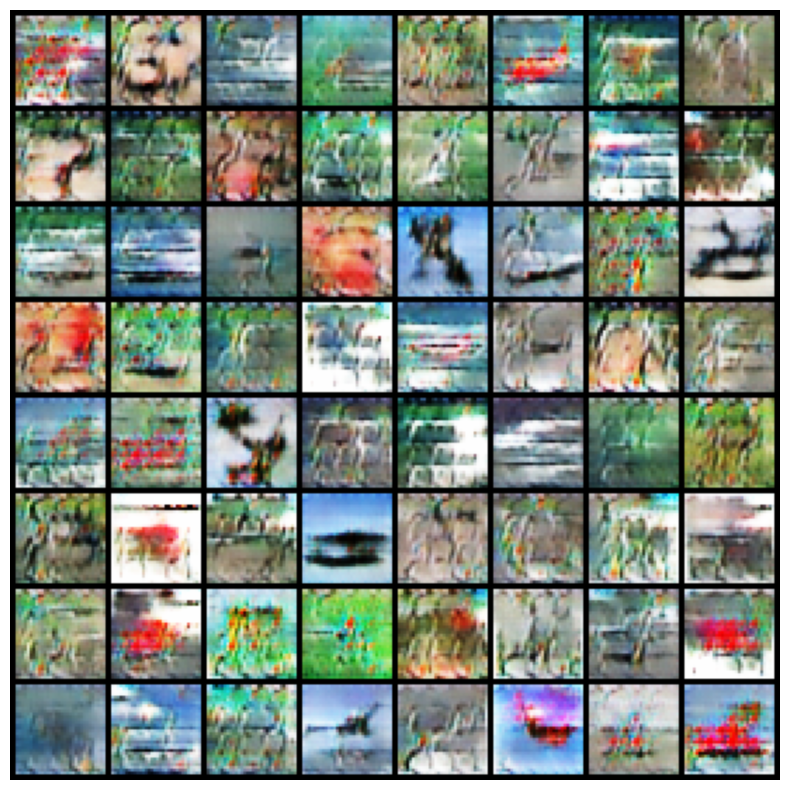

Unique classes: 15/10, Diversity score: 1.50
VAE Reconstruction Error (MSE per pixel): 0.049126
=== Comparison Report ===
vae_reconstruction_error: 0.04912608861923218
gan_diversity_score: 1.5
Comparison figure saved at: /content/drive/MyDrive/vae_gan_models/logs/comparison_report_epoch_latest.png
Evaluation report metrics: {'vae_reconstruction_error': 0.04912608861923218, 'gan_diversity_score': 1.5}


In [ ]:

#DIVERSITY SCORE
def main_evaluation(epoch=None, n_samples=64):
    vae = VAE(latent_dim=config.vae_latent_dim).to(device)
    generator = Generator(
        latent_dim=config.gan_latent_dim,
        feature_dim=config.gan_feature_dim,
        num_channels=config.num_channels
    ).to(device)
    discriminator = Discriminator(
        feature_dim=config.gan_feature_dim,
        num_channels=config.num_channels
    ).to(device)

    import glob
    if epoch is not None:
        vae_path = os.path.join(model_dir, f'vae_epoch_{epoch}.pth')
        gen_path = os.path.join(model_dir, f'gan_generator_epoch_{epoch}.pth')
        disc_path = os.path.join(model_dir, f'gan_discriminator_epoch_{epoch}.pth')
    else:
        vae_path = sorted(glob.glob(os.path.join(model_dir, 'vae_epoch_*.pth')))[-1]
        gen_path = sorted(glob.glob(os.path.join(model_dir, 'gan_generator_epoch_*.pth')))[-1]
        disc_path = sorted(glob.glob(os.path.join(model_dir, 'gan_discriminator_epoch_*.pth')))[-1]

    vae.load_state_dict(torch.load(vae_path, map_location=device))
    generator.load_state_dict(torch.load(gen_path, map_location=device))
    discriminator.load_state_dict(torch.load(disc_path, map_location=device))

    print(f"Loaded models from epoch {epoch if epoch else 'latest'}")

    report_filename = os.path.join(logs_dir, f'comparison_report_epoch_{epoch if epoch else "latest"}.png')
    report, grid = generate_comparison_report(test_loader, vae, generator, n_samples=n_samples, filename=report_filename)

    print("Comparison figure saved at:", report_filename)
    print("Evaluation report metrics:", report)

    return report, grid

if __name__ == "__main__":
    main_evaluation(epoch=None, n_samples=64)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#LATENT INTERPOLATION
def load_trained_models(epoch=None):
    vae = VAE(latent_dim=config.vae_latent_dim).to(device)
    generator = Generator(latent_dim=config.gan_latent_dim, feature_dim=config.gan_feature_dim,
                          num_channels=config.num_channels).to(device)

    if epoch is not None:
       vae_path = os.path.join(model_dir, f'vae_epoch_{epoch}.pth')
       gen_path = os.path.join(model_dir, f'gan_generator_epoch_{epoch}.pth')
    else:
        import glob
        vae_path = sorted(glob.glob(os.path.join(model_dir, 'vae_epoch_*.pth')))[-1]
        gen_path = sorted(glob.glob(os.path.join(model_dir, 'gan_generator_epoch_*.pth')))[-1]

    vae.load_state_dict(torch.load(vae_path, map_location=device))
    generator.load_state_dict(torch.load(gen_path, map_location=device))

    vae.eval()
    generator.eval()
    return vae, generator

--
def setup_visualization(figsize=(12, 6)):
    plt.figure(figsize=figsize)
    plt.axis('off')


def save_analysis_results(images, filename, nrow=8):
    save_image(images, filename, nrow=nrow, normalize=True)


def compute_metrics_batch(images, targets=None):
    return {'placeholder_metric': 0}

def interpolate_latent_vectors(z1, z2, n_steps=10):
    ratios = torch.linspace(0, 1, n_steps).to(device)
    interpolations = [(1 - r) * z1 + r * z2 for r in ratios]
    return torch.stack(interpolations)


def create_latent_interpolation_figure(images, filename):
    setup_visualization(figsize=(len(images), 1))
    grid = make_grid(images, nrow=len(images), normalize=True)
    save_image(grid, filename)
    plt.close()


def extract_latent_representations(model, dataloader, n_samples=None):
    latents = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu())
            labels.append(target)
            if n_samples and len(latents)*config.batch_size >= n_samples:
                break
    latents = torch.cat(latents)[:n_samples]
    labels = torch.cat(labels)[:n_samples]
    return latents, labels


def perform_latent_space_visualization(latents, labels=None, method='pca', filename='latent_space.png'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2, init='pca', random_state=42)
    reduced = reducer.fit_transform(latents)

    plt.figure(figsize=(8, 6))
    if labels is not None:
        for c in torch.unique(labels):
            mask = labels == c
            plt.scatter(reduced[mask, 0], reduced[mask, 1], label=int(c), alpha=0.6)
        plt.legend()
    else:
        plt.scatter(reduced[:,0], reduced[:,1], alpha=0.6)
    plt.title(f'Latent space ({method.upper()})')
    plt.savefig(filename)
    plt.close()


def vary_latent_dimensions(model, z, dim_indices, steps=5):
    variations = []
    for dim in dim_indices:
        vals = torch.linspace(-3, 3, steps).to(device)
        for v in vals:
            z_mod = z.clone()
            z_mod[:, dim] = v
            x_gen = model.decode(z_mod)
            variations.append(x_gen.cpu())
    return variations


def create_latent_variation_grid(variations, filename, nrow=5):
    grid = make_grid(torch.cat(variations), nrow=nrow, normalize=True)
    save_image(grid, filename)


def generate_latent_analysis_report(vae, generator, test_loader, n_samples=64, filename_prefix='latent_analysis'):
    latents, labels = extract_latent_representations(vae, test_loader, n_samples=n_samples)

    perform_latent_space_visualization(latents, labels, method='pca',
                                       filename=f'logs/{filename_prefix}_pca.png')
    perform_latent_space_visualization(latents, labels, method='tsne',
                                       filename=f'logs/{filename_prefix}_tsne.png')

    z1, z2 = latents[0:1].to(device), latents[1:2].to(device)
    interpolations = interpolate_latent_vectors(z1, z2, n_steps=10)
    interp_images = vae.decode(interpolations)
    create_latent_interpolation_figure(interp_images.cpu(), f'results/vae/{filename_prefix}_interp.png')

    z_base = latents[0:1].to(device)
    variations = vary_latent_dimensions(vae, z_base, dim_indices=list(range(5)), steps=5)
    create_latent_variation_grid(variations, f'results/vae/{filename_prefix}_variations.png', nrow=5)

    return {
        'latents': latents,
        'labels': labels,
        'interpolation_images': interp_images.cpu(),
        'variation_images': variations
    }


In [ ]:

def run_full_latent_analysis(epoch=None, n_samples=64):

    os.makedirs('results/vae', exist_ok=True)
    os.makedirs('results/gan', exist_ok=True)

    vae, generator = load_trained_models(epoch)

    print(f"Loaded models from epoch {epoch if epoch else 'latest'}")

    results = generate_latent_analysis_report(
        vae, generator, test_loader,
        n_samples=n_samples,
        filename_prefix=f'epoch_{epoch if epoch else "latest"}'
    )

    z1 = torch.randn(1, config.gan_latent_dim).to(device)
    z2 = torch.randn(1, config.gan_latent_dim).to(device)
    gan_interpolations = interpolate_latent_vectors(z1, z2, n_steps=10)
    gan_images = generator(gan_interpolations)
    create_latent_interpolation_figure(
        gan_images.cpu(),
        f'results/gan/epoch_{epoch if epoch else "latest"}_interp.png'
    )

    print("Latent space analysis completed. VAE figures saved in results/vae and logs/, GAN interpolation saved in results/gan/")
    print(f"Latents shape: {results['latents'].shape}, Interpolation images: {results['interpolation_images'].shape}")

    return results, gan_images

if __name__ == "__main__":
    latent_results, gan_interp_images = run_full_latent_analysis(epoch=None, n_samples=64)


Loaded models from epoch latest
Latent space analysis completed. VAE figures saved in results/vae and logs/, GAN interpolation saved in results/gan/
Latents shape: torch.Size([64, 128]), Interpolation images: torch.Size([10, 3, 32, 32])


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



def run_latent_analysis_memory(test_loader, model_class_vae, model_class_gen, model_dir, device,
                               epochs=None, n_samples=128, top_latent_dims=5):
    """
    Perform latent space analysis without saving to disk.
    Returns results dictionary and prints summaries.
    """
    import glob
    all_results = {}

    if epochs is None:
        vae_ckpts = sorted(glob.glob(f"{model_dir}/vae_epoch_*.pth"))
        epochs = [int(p.split('_')[-1].split('.')[0]) for p in vae_ckpts[-1:]]

    for epoch in epochs:
        print(f"\n=== Latent Space Analysis: Epoch {epoch} ===")

        vae = model_class_vae(latent_dim=config.vae_latent_dim).to(device)
        generator = model_class_gen(latent_dim=config.gan_latent_dim,
                                    feature_dim=config.gan_feature_dim,
                                    num_channels=config.num_channels).to(device)

        vae.load_state_dict(torch.load(f"{model_dir}/vae_epoch_{epoch}.pth", map_location=device))
        generator.load_state_dict(torch.load(f"{model_dir}/gan_generator_epoch_{epoch}.pth", map_location=device))
        vae.eval(); generator.eval()

        latents, labels = [], []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data = data.to(device)
                mu, _ = vae.encode(data)
                latents.append(mu.cpu())
                labels.append(target)
                if n_samples and len(latents)*config.batch_size >= n_samples:
                    break
        latents = torch.cat(latents)[:n_samples]
        labels = torch.cat(labels)[:n_samples]

        figures = {}
        for method in ['pca', 'tsne']:
            if method == 'pca':
                reducer = PCA(n_components=2)
            else:
                reducer = TSNE(n_components=2, init='pca', random_state=42)

            reduced = reducer.fit_transform(latents)
            fig, ax = plt.subplots(figsize=(8,6))
            for c in torch.unique(labels):
                mask = labels == c
                ax.scatter(reduced[mask, 0], reduced[mask, 1], label=int(c), alpha=0.6)
            ax.legend(title='Class')
            ax.set_title(f'Epoch {epoch}: Latent space ({method.upper()})')
            ax.set_xlabel('Dim 1'); ax.set_ylabel('Dim 2')
            ax.grid(True)
            figures[method] = fig
            plt.close(fig)

        z1, z2 = latents[0:1].to(device), latents[1:2].to(device)
        ratios = torch.linspace(0,1,10).to(device)
        interpolations = torch.stack([(1 - r) * z1 + r * z2 for r in ratios])
        interp_images = vae.decode(interpolations)
        interp_grid = make_grid(interp_images.cpu(), nrow=len(interpolations), normalize=True)

        z_base = latents[0:1].to(device)
        variations = []
        for dim in range(min(top_latent_dims, latents.shape[1])):
            vals = torch.linspace(-3, 3, 5).to(device)
            for v in vals:
                z_mod = z_base.clone()
                z_mod[:, dim] = v
                variations.append(vae.decode(z_mod).cpu())
        variation_grid = make_grid(torch.cat(variations), nrow=5, normalize=True)

        print(f"Latents shape: {latents.shape}, Labels shape: {labels.shape}")
        print(f"Interpolation grid shape: {interp_grid.shape}, Variation grid shape: {variation_grid.shape}")

        all_results[epoch] = {
            'latents': latents,
            'labels': labels,
            'figures': figures,
            'interp_grid': interp_grid,
            'variation_grid': variation_grid
        }

    print("\n=== Latent Analysis Complete ===")
    return all_results


if __name__ == "__main__":
    results = run_latent_analysis_memory(
        test_loader=test_loader,
        model_class_vae=VAE,
        model_class_gen=Generator,
        model_dir=model_dir,
        device=device,
        epochs=None, 
        n_samples=64,
        top_latent_dims=5
    )

    for epoch, res in results.items():
        print(f"\nEpoch {epoch} analysis keys: {list(res.keys())}")
        res['figures']['pca'].show()



=== Latent Space Analysis: Epoch 9 ===
Latents shape: torch.Size([64, 128]), Labels shape: torch.Size([64])
Interpolation grid shape: torch.Size([3, 36, 342]), Variation grid shape: torch.Size([3, 172, 172])

=== Latent Analysis Complete ===

Epoch 9 analysis keys: ['latents', 'labels', 'figures', 'interp_grid', 'variation_grid']


In [ ]:
from sklearn.metrics import roc_auc_score
#OOD
def show_image_tensor(img_tensor, title="Image"):
    img = img_tensor.cpu().detach().numpy()
    img = (img + 1) / 2  
    img = np.transpose(img, (1, 2, 0))  
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


def load_ood_datasets():
    transform = transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    cifar100 = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    svhn = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
    return cifar100, svhn


def prepare_ood_samples(dataset, num_samples=64):
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    data_iter = iter(loader)
    imgs, _ = next(data_iter)
    return imgs.to(device)

def vae_ood_reconstruction(vae, ood_images):
    vae.eval()
    with torch.no_grad():
        recon, _, _ = vae(ood_images)
    for i in range(min(5, recon.size(0))):
        show_image_tensor(ood_images[i], title="Original OOD Image")
        show_image_tensor(recon[i], title="VAE Reconstruction")
    return recon
def detect_ood(images, classifier, threshold_std=2.0):
    probs = predict_classes(images)
    entropies = -(probs * torch.log(probs + 1e-8)).sum(dim=1)
    mean_entropy = entropies.mean()
    std_entropy = entropies.std()

    ood_mask = entropies > (mean_entropy + threshold_std * std_entropy)
    return ood_mask
def per_class_diversity(images):
    probs = predict_classes(images)
    preds = probs.argmax(dim=1)
    diversity_per_class = {}
    for cls in preds.unique():
        cls_probs = probs[preds == cls]
        mean_probs = cls_probs.mean(dim=0)
        diversity_per_class[int(cls)] = -(mean_probs * torch.log(mean_probs + 1e-8)).sum().item()
    return diversity_per_class



def analyze_ood_reconstructions(recon_ood, in_dist_images, vae):
    vae.eval()
    with torch.no_grad():
        recon_in, _, _ = vae(in_dist_images)
    return recon_in

def compute_ood_reconstruction_error(recon, original):
    mse = F.mse_loss(recon, original, reduction='none')
    mse_per_sample = mse.view(mse.size(0), -1).mean(dim=1)
    return mse_per_sample

def gan_latent_extrapolation(generator, extreme_scale=5.0, num_samples=64):
    generator.eval()
    with torch.no_grad():
        extreme_latents = torch.randn(num_samples, config.gan_latent_dim, device=device) * extreme_scale
        generated = generator(extreme_latents)
    for i in range(min(5, generated.size(0))):
        show_image_tensor(generated[i], title="GAN Extreme Latent Sample")
    return generated

def evaluate_extrapolation_quality(generated_images):
    pixel_var = generated_images.view(generated_images.size(0), -1).var(dim=1)
    print("Mean pixel variance of generated extreme samples:", pixel_var.mean().item())
    return pixel_var

def perform_anomaly_detection(vae, in_dist_images, ood_images):
    vae.eval()
    with torch.no_grad():
        recon_in, _, _ = vae(in_dist_images)
        recon_ood, _, _ = vae(ood_images)
    mse_in = compute_ood_reconstruction_error(recon_in, in_dist_images)
    mse_ood = compute_ood_reconstruction_error(recon_ood, ood_images)
    return mse_in, mse_ood

def calculate_anomaly_detection_metrics(mse_in, mse_ood):
    y_true = torch.cat([torch.zeros_like(mse_in), torch.ones_like(mse_ood)]).cpu().numpy()
    y_scores = torch.cat([mse_in, mse_ood]).cpu().numpy()
    auc = roc_auc_score(y_true, y_scores)
    print("Anomaly Detection ROC-AUC:", auc)
    return auc

def visualize_ood_results(mse_in, mse_ood):
    plt.figure(figsize=(6,4))
    plt.hist(mse_in.cpu().numpy(), bins=30, alpha=0.5, label="In-Distribution")
    plt.hist(mse_ood.cpu().numpy(), bins=30, alpha=0.5, label="OOD")
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("MSE per sample")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def generate_ood_analysis_report(mse_in, mse_ood, auc, pixel_var_extreme):
    print("==== OOD Analysis Report ====")
    print(f"In-Distribution Mean MSE: {mse_in.mean().item():.4f}")
    print(f"OOD Mean MSE: {mse_ood.mean().item():.4f}")
    print(f"ROC-AUC for Anomaly Detection: {auc:.4f}")
    print(f"Mean Pixel Variance of GAN Extreme Samples: {pixel_var_extreme.mean().item():.4f}")
    print("============================")

def sample_extreme_latents(num_samples=64, scale=5.0):
    return torch.randn(num_samples, config.gan_latent_dim, device=device) * scale

def compute_reconstruction_error_distribution(vae, dataset, num_samples=64):
    imgs = prepare_ood_samples(dataset, num_samples)
    vae.eval()
    with torch.no_grad():
        recon, _, _ = vae(imgs)
    mse = compute_ood_reconstruction_error(recon, imgs)
    return mse

def set_anomaly_detection_threshold(mse_in, percentile=95):
    threshold = np.percentile(mse_in.cpu().numpy(), percentile)
    print(f"Anomaly detection threshold set at {percentile}th percentile: {threshold:.4f}")
    return threshold



Starting Out-of-Distribution (OOD) Evaluation...


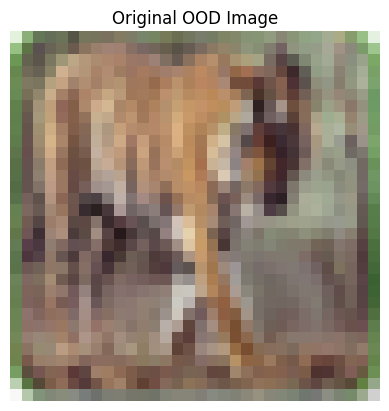

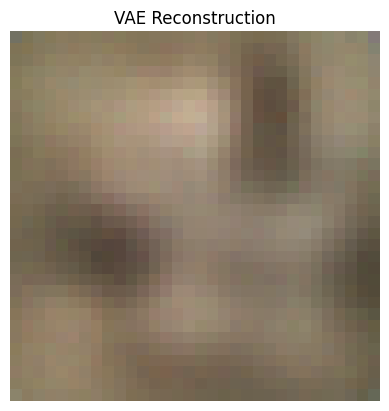

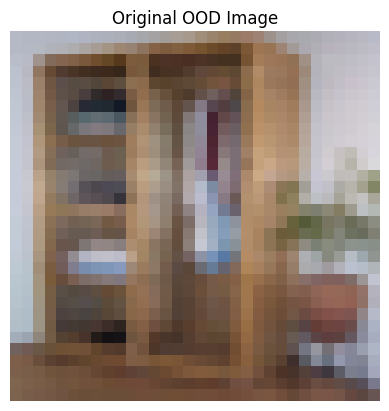

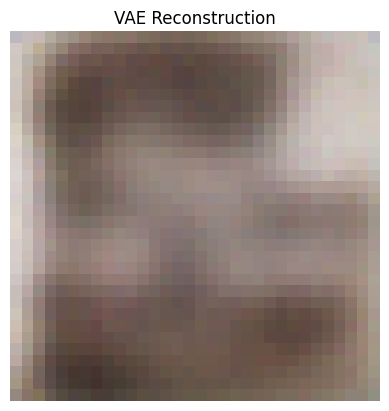

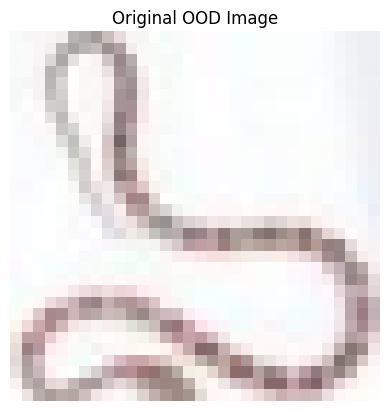

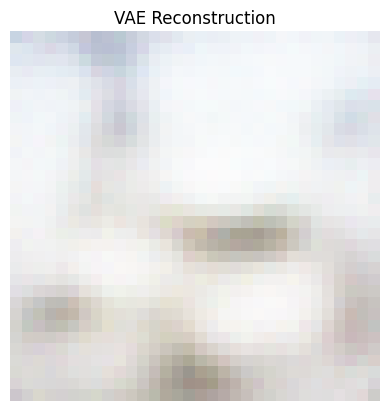

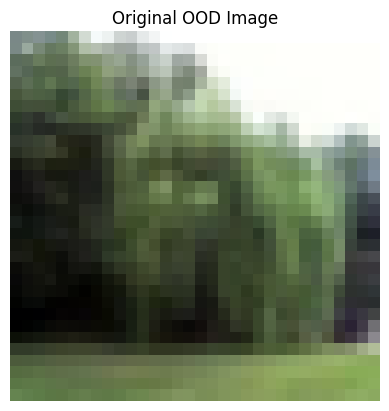

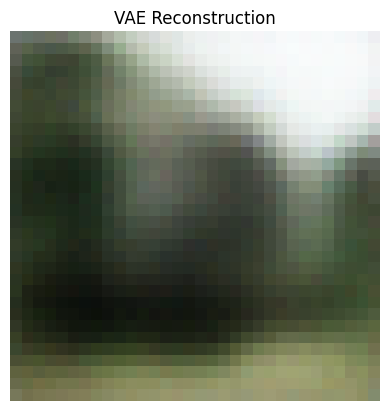

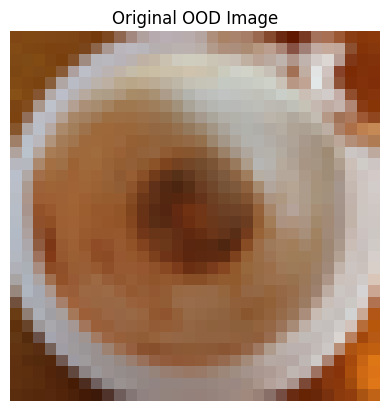

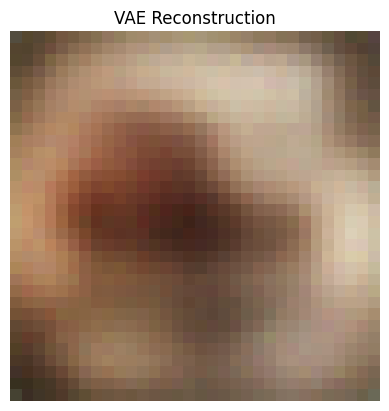

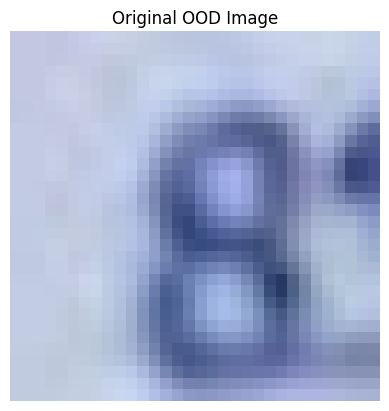

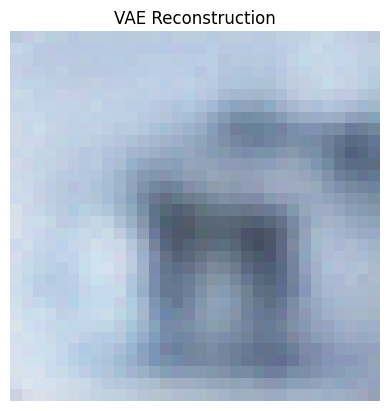

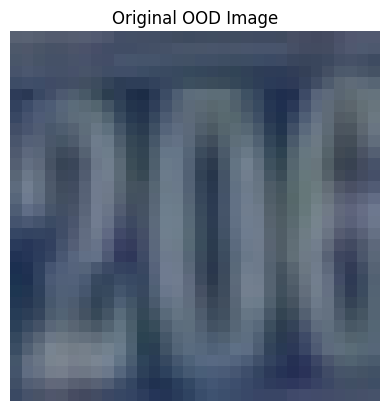

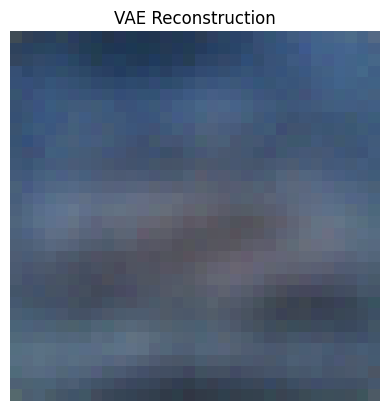

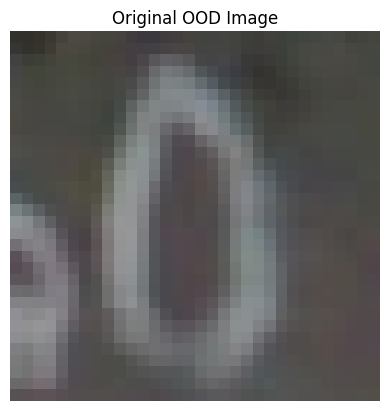

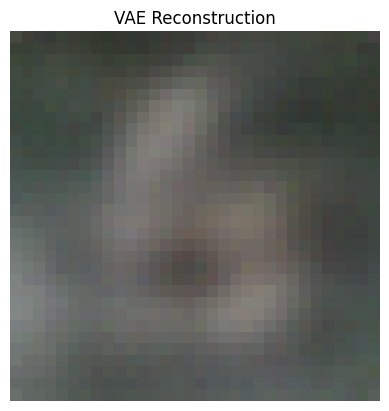

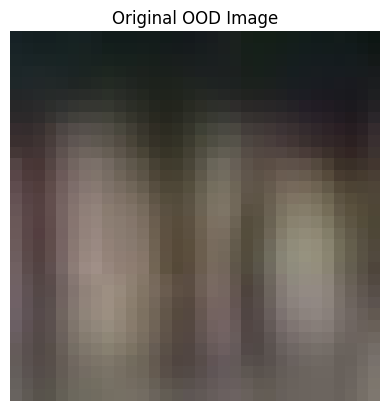

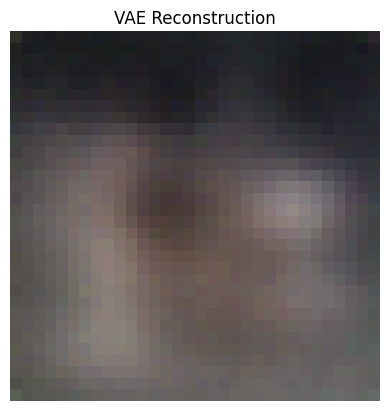

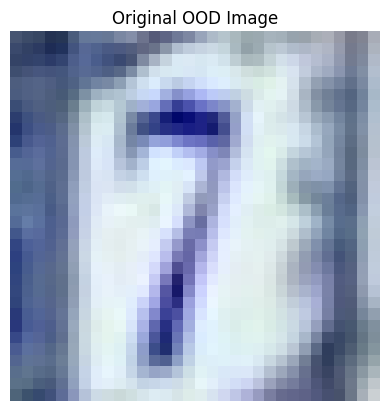

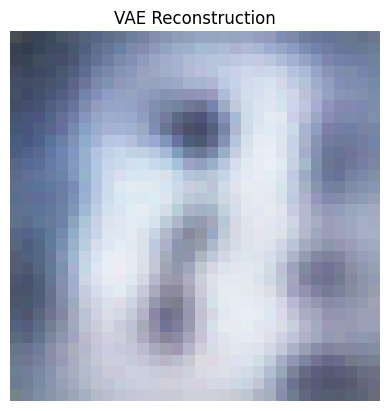

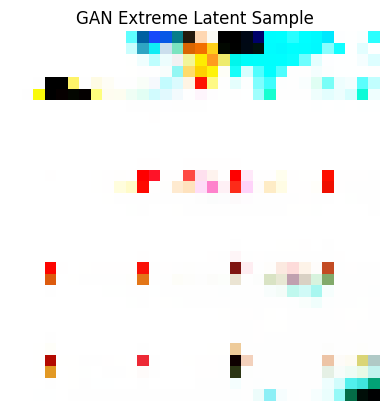

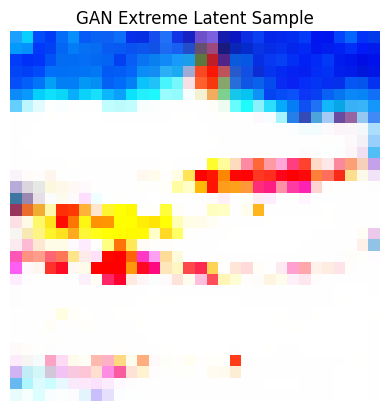

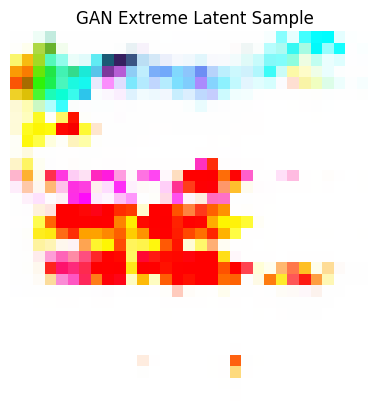

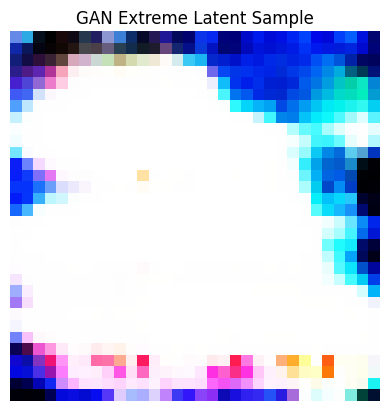

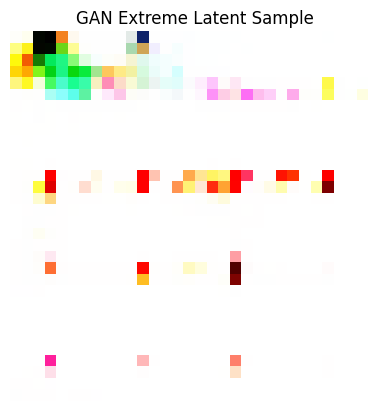

Mean pixel variance of generated extreme samples: 0.33451780676841736


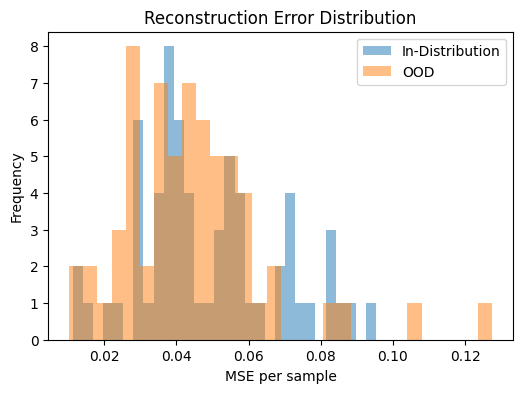

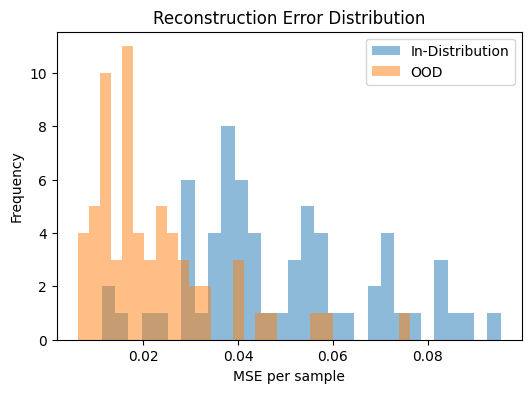

==== OOD Analysis Report ====
In-Distribution Mean MSE: 0.0443
OOD Mean MSE: 0.0219
ROC-AUC for Anomaly Detection: 0.4219
Mean Pixel Variance of GAN Extreme Samples: 0.3345
Anomaly detection threshold set at 95th percentile: 0.0835
OOD Evaluation Completed!


In [ ]:
def run_ood_evaluation(vae, generator, test_loader, num_samples=64):
    print("\nStarting Out-of-Distribution (OOD) Evaluation...")

    cifar100, svhn = load_ood_datasets()
    ood_cifar100 = prepare_ood_samples(cifar100, num_samples=num_samples)
    ood_svhn = prepare_ood_samples(svhn, num_samples=num_samples)

    in_dist_images, _ = next(iter(test_loader))
    in_dist_images = in_dist_images.to(device)[:num_samples]

    recon_cifar100 = vae_ood_reconstruction(vae, ood_cifar100)
    recon_svhn = vae_ood_reconstruction(vae, ood_svhn)

    mse_in, mse_cifar100 = perform_anomaly_detection(vae, in_dist_images, ood_cifar100)
    _, mse_svhn = perform_anomaly_detection(vae, in_dist_images, ood_svhn)
    auc_cifar100 = calculate_anomaly_detection_metrics(mse_in, mse_cifar100)
    auc_svhn = calculate_anomaly_detection_metrics(mse_in, mse_svhn)

    extreme_samples = gan_latent_extrapolation(generator, extreme_scale=5.0, num_samples=num_samples)
    pixel_var_extreme = evaluate_extrapolation_quality(extreme_samples)

    visualize_ood_results(mse_in, mse_cifar100)
    visualize_ood_results(mse_in, mse_svhn)

    generate_ood_analysis_report(mse_cifar100, mse_svhn, auc_cifar100, pixel_var_extreme)

    threshold = set_anomaly_detection_threshold(mse_in)
    print("OOD Evaluation Completed!")

    return {
        'mse_in': mse_in,
        'mse_cifar100': mse_cifar100,
        'mse_svhn': mse_svhn,
        'auc_cifar100': auc_cifar100,
        'auc_svhn': auc_svhn,
        'extreme_samples': extreme_samples,
        'pixel_var_extreme': pixel_var_extreme,
        'threshold': threshold
    }



if __name__ == "__main__":
    vae, generator = load_trained_models(epoch=None)  
    results_ood = run_ood_evaluation(vae, generator, test_loader, num_samples=64)


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

#TRAINING PROCESS->ANALYSIS

def analyze_training_stability(history, model_type='vae'):
    """
    Plot and analyze the stability of the training loss curves.
    """
    plt.figure(figsize=(8, 5))

    if model_type == 'vae':
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history.get('test_loss', []), label='Test Loss')
        plt.title("VAE Training Stability")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

    elif model_type == 'gan':
        plt.plot(history['d_loss'], label='Discriminator Loss')
        plt.plot(history['g_loss'], label='Generator Loss')
        plt.plot(history['real_score'], label='Real Score')
        plt.plot(history['fake_score'], label='Fake Score')
        plt.title("GAN Training Stability")
        plt.xlabel("Epochs")
        plt.ylabel("Loss / Score")
        plt.legend()
        plt.grid(True)

    plt.show()

def compare_training_dynamics(vae_history, gan_history):
    """
    Compare VAE and GAN losses visually.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(vae_history['train_loss'], label='VAE Train Loss')
    plt.plot(vae_history.get('test_loss', []), label='VAE Test Loss')
    plt.title("VAE Training Dynamics")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(gan_history['d_loss'], label='Discriminator Loss')
    plt.plot(gan_history['g_loss'], label='Generator Loss')
    plt.title("GAN Training Dynamics")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_convergence_behavior(history, model_type='vae'):
    """
    Compute the final convergence statistics (mean and std of last 10 epochs).
    """
    if model_type == 'vae':
        last_epochs = history['train_loss'][-10:]
        mean_loss = np.mean(last_epochs)
        std_loss = np.std(last_epochs)
        return mean_loss, std_loss
    elif model_type == 'gan':
        last_d = history['d_loss'][-10:]
        last_g = history['g_loss'][-10:]
        return np.mean(last_d), np.mean(last_g), np.std(last_d), np.std(last_g)

def detect_mode_collapse(generator, latent_dim, device, num_samples=1000):
    """
    Generate samples and count unique modes/classes using simple heuristics.
    For CIFAR-10, we can use a pretrained classifier if available (optional).
    Here, we measure pixel-level uniqueness as a proxy.
    """
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim, device=device)
        samples = generator(noise)
        samples_flat = samples.view(num_samples, -1)
    
        _, unique_indices = torch.unique(samples_flat, dim=0, return_inverse=True)
        diversity_ratio = len(unique_indices) / num_samples
    return diversity_ratio

def quantify_fidelity_vs_diversity(generator, latent_dim, device, num_samples=100):
    """
    Generate sample images and estimate rough fidelity vs. diversity.
    - Fidelity: using image sharpness (variance of Laplacian)
    - Diversity: average pairwise L2 distance
    """
    import cv2   Only for fidelity calculation

    generator.eval()
    samples = []
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim, device=device)
        gen_images = generator(noise).cpu().numpy() 
    sharpness_list = []
    for img in gen_images:
        img_gray = cv2.cvtColor(((img.transpose(1, 2, 0) + 1) * 127.5).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        laplacian_var = cv2.Laplacian(img_gray, cv2.CV_64F).var()
        sharpness_list.append(laplacian_var)

    fidelity = np.mean(sharpness_list)

    flattened = gen_images.reshape(num_samples, -1)
    pairwise_dist = np.sqrt(((flattened[:, None, :] - flattened[None, :, :]) ** 2).sum(-1))
    diversity = pairwise_dist.mean()

    return fidelity, diversity

def summarize_model_biases(vae_history, gan_diversity):
    """
    Summarize observed biases in VAE vs GAN.
    """
    summary = {}
    summary['vae_bias'] = "VAE shows blurrier outputs but better coverage of the latent space."
    summary['gan_bias'] = f"GAN produces sharp outputs but might suffer from mode collapse/diversity loss: diversity_ratio={gan_diversity:.3f}"
    return summary

def generate_training_analysis_report(vae_history, gan_history, generator, config, device):
    """
    Generate a structured training analysis report.
    """
    print("==== Training Analysis Report ====")

    print("\nVAE Training Stability:")
    analyze_training_stability(vae_history, model_type='vae')

    print("\nGAN Training Stability:")
    analyze_training_stability(gan_history, model_type='gan')

    vae_mean, vae_std = evaluate_convergence_behavior(vae_history, model_type='vae')
    print(f"\nVAE Convergence over last 10 epochs: mean={vae_mean:.4f}, std={vae_std:.4f}")

    gan_d_mean, gan_g_mean, gan_d_std, gan_g_std = evaluate_convergence_behavior(gan_history, model_type='gan')
    print(f"GAN Convergence (last 10 epochs): D_mean={gan_d_mean:.4f}, G_mean={gan_g_mean:.4f}, "
          f"D_std={gan_d_std:.4f}, G_std={gan_g_std:.4f}")

    gan_diversity = detect_mode_collapse(generator, config.gan_latent_dim, device)
    print(f"GAN Mode Collapse / Diversity Ratio: {gan_diversity:.3f}")

    fidelity, diversity = quantify_fidelity_vs_diversity(generator, config.gan_latent_dim, device)
    print(f"GAN Fidelity (sharpness): {fidelity:.3f}, Diversity (avg L2): {diversity:.3f}")

    biases = summarize_model_biases(vae_history, gan_diversity)
    print("\nModel Bias Summary:")
    print(f"VAE: {biases['vae_bias']}")
    print(f"GAN: {biases['gan_bias']}")

    print("==== End of Report ====")

def produce_final_comparison_summary(vae_history, gan_history, generator, config, device):
    """
    Provide a concise final comparison summary between VAE and GAN.
    """
    print("==== Final Comparison Summary ====")

    vae_final_loss = vae_history['train_loss'][-1]
    print(f"VAE final training loss: {vae_final_loss:.4f}")

    gan_final_g = gan_history['g_loss'][-1]
    gan_final_d = gan_history['d_loss'][-1]
    print(f"GAN final losses: Generator={gan_final_g:.4f}, Discriminator={gan_final_d:.4f}")

    gan_diversity = detect_mode_collapse(generator, config.gan_latent_dim, device)
    print(f"GAN diversity ratio: {gan_diversity:.3f}")

    print("Observation:")
    print("- VAE: smooth latent space, reconstructs inputs, lower fidelity but high coverage.")
    print("- GAN: high-fidelity samples, adversarially trained, may suffer mode collapse or low diversity.")
    print("==== End of Summary ====")


==== Running Full GAN Analysis ====
GAN Mode Collapse / Diversity Ratio: 1.000
GAN Fidelity (sharpness): 5028.621
GAN Diversity (avg L2 distance): 32.563

Model Bias Summary:
VAE: VAE outputs generally blurry but cover latent space well (cannot measure quantitatively here).
GAN: GAN produces sharp outputs but may suffer from mode collapse/diversity loss: diversity_ratio=1.000


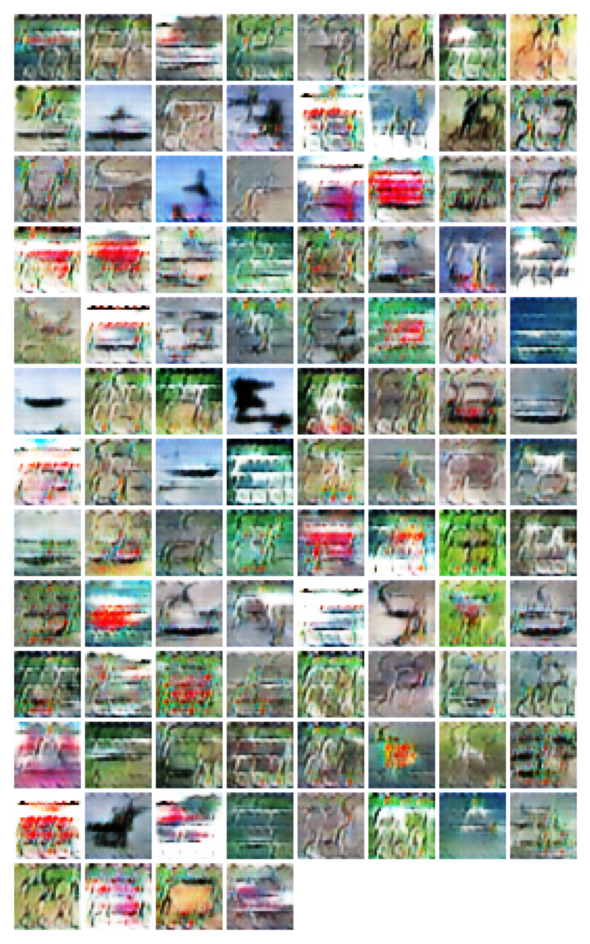


Sample images saved and displayed at: results/gan/generated_samples.png
==== End of GAN Analysis ====


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from torchvision.utils import make_grid, save_image


def detect_mode_collapse(generator, latent_dim, device, num_samples=1000):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim, device=device)
        samples = generator(noise)
        samples_flat = samples.view(num_samples, -1)
        _, unique_indices = torch.unique(samples_flat, dim=0, return_inverse=True)
        diversity_ratio = len(unique_indices) / num_samples
    return diversity_ratio

def quantify_fidelity_vs_diversity(generator, latent_dim, device, num_samples=100):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim, device=device)
        gen_images = generator(noise).cpu().numpy()
    sharpness_list = []
    for img in gen_images:
        img_gray = cv2.cvtColor(((img.transpose(1,2,0)+1)*127.5).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        sharpness_list.append(cv2.Laplacian(img_gray, cv2.CV_64F).var())
    fidelity = np.mean(sharpness_list)
    flattened = gen_images.reshape(num_samples, -1)
    pairwise_dist = np.sqrt(((flattened[:, None, :] - flattened[None, :, :])**2).sum(-1))
    diversity = pairwise_dist.mean()
    return fidelity, diversity, torch.tensor(gen_images)

def create_visual_report(gen_images, filename='results/gan/generated_samples.png', n_row=8):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    grid = make_grid(gen_images, nrow=n_row, normalize=True, pad_value=1)
    save_image(grid, filename, normalize=True)
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
    plt.axis('off')
    plt.show()
    return filename

def summarize_model_biases(gan_diversity):
    summary = {}
    summary['vae_bias'] = "VAE outputs generally blurry but cover latent space well (cannot measure quantitatively here)."
    summary['gan_bias'] = f"GAN produces sharp outputs but may suffer from mode collapse/diversity loss: diversity_ratio={gan_diversity:.3f}"
    return summary


generator.eval()
device = next(generator.parameters()).device

print("==== Running Full GAN Analysis ====")

gan_diversity = detect_mode_collapse(generator, config.gan_latent_dim, device, num_samples=1000)
print(f"GAN Mode Collapse / Diversity Ratio: {gan_diversity:.3f}")

fidelity, diversity, gen_images = quantify_fidelity_vs_diversity(generator, config.gan_latent_dim, device, num_samples=100)
print(f"GAN Fidelity (sharpness): {fidelity:.3f}")
print(f"GAN Diversity (avg L2 distance): {diversity:.3f}")

biases = summarize_model_biases(gan_diversity)
print("\nModel Bias Summary:")
print(f"VAE: {biases['vae_bias']}")
print(f"GAN: {biases['gan_bias']}")

visual_file = create_visual_report(gen_images, filename=f'results/gan/generated_samples.png', n_row=8)
print(f"\nSample images saved and displayed at: {visual_file}")
print("==== End of GAN Analysis ====")


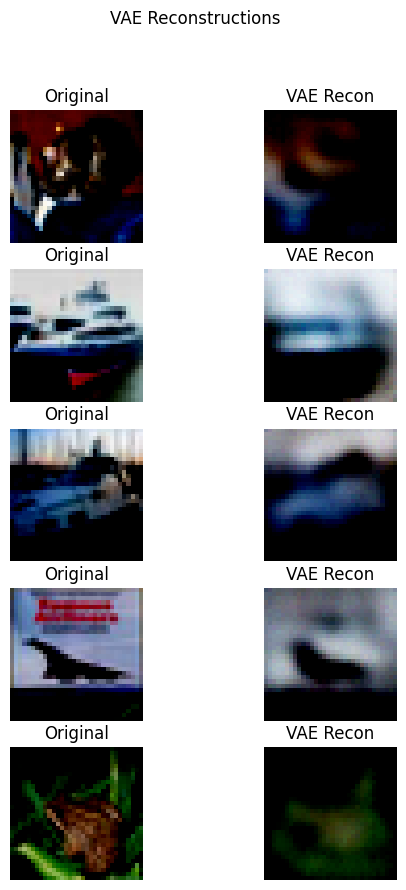

Step 0/300 | Recon Loss: 0.4328
Step 100/300 | Recon Loss: 0.0720
Step 200/300 | Recon Loss: 0.0599


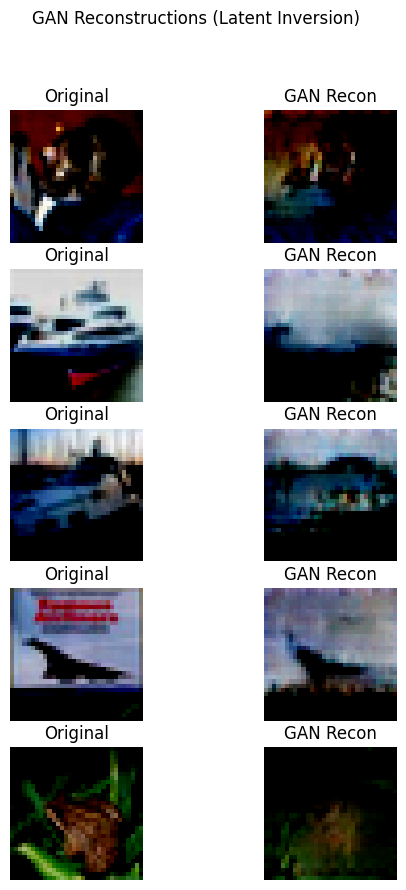

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


def reconstruct_with_vae(vae, data_loader, device="cuda", num_samples=5):
    vae.eval()
    imgs, _ = next(iter(data_loader))
    imgs = imgs[:num_samples].to(device)

    with torch.no_grad():
        recon, _, _ = vae(imgs)

    fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples*2))
    for i in range(num_samples):
        axes[i, 0].imshow(imgs[i].cpu().permute(1,2,0).squeeze(), cmap="gray")
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(recon[i].cpu().permute(1,2,0).squeeze(), cmap="gray")
        axes[i, 1].set_title("VAE Recon")
        axes[i, 1].axis("off")

    plt.suptitle("VAE Reconstructions")
    plt.show()
    return imgs, recon



def reconstruct_with_gan(generator, data_loader, device="cuda", num_samples=5, latent_dim=100, steps=500, lr=0.05):
    generator.eval()
    imgs, _ = next(iter(data_loader))
    imgs = imgs[:num_samples].to(device)


    z = torch.randn(num_samples, latent_dim, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([z], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        gen_imgs = generator(z)
        loss = F.mse_loss(gen_imgs, imgs)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}/{steps} | Recon Loss: {loss.item():.4f}")

    with torch.no_grad():
        final_recon = generator(z)


    fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples*2))
    for i in range(num_samples):
        axes[i, 0].imshow(imgs[i].cpu().permute(1,2,0).squeeze(), cmap="gray")
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(final_recon[i].cpu().permute(1,2,0).squeeze(), cmap="gray")
        axes[i, 1].set_title("GAN Recon")
        axes[i, 1].axis("off")

    plt.suptitle("GAN Reconstructions (Latent Inversion)")
    plt.show()

    return imgs, final_recon







vae_imgs, vae_recons = reconstruct_with_vae(vae, test_loader, device=device, num_samples=5)

gan_imgs, gan_recons = reconstruct_with_gan(generator, test_loader, device=device,
                                           num_samples=5, latent_dim=config.gan_latent_dim,
                                           steps=300, lr=0.05)






Running VAE interpolation...


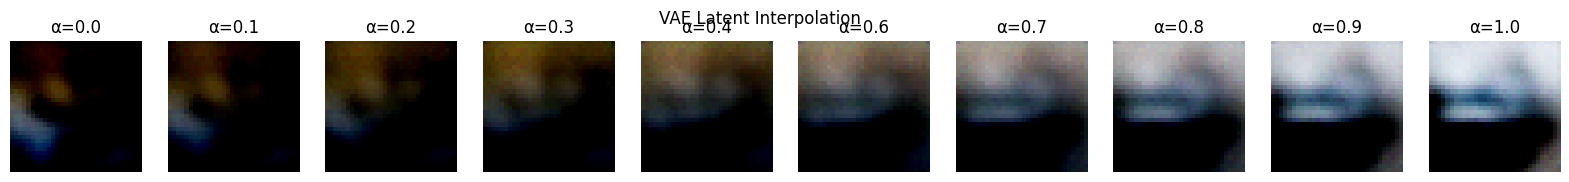

Running GAN interpolation...


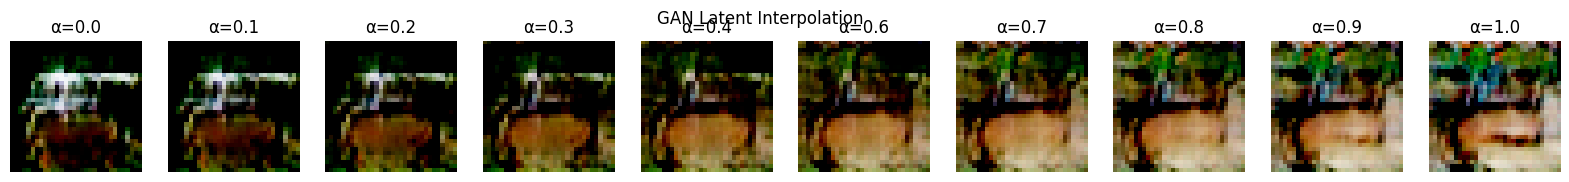

Analyzing VAE latent representations...


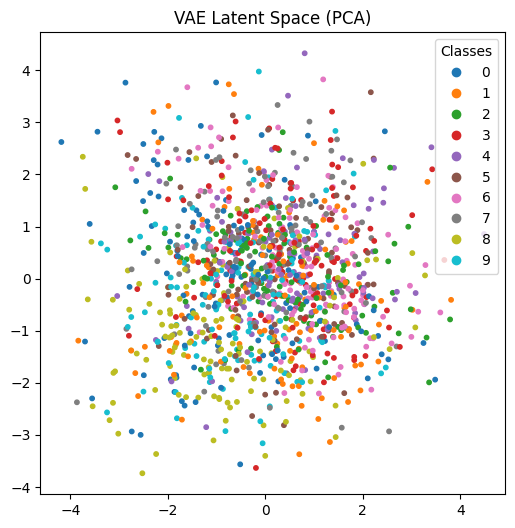

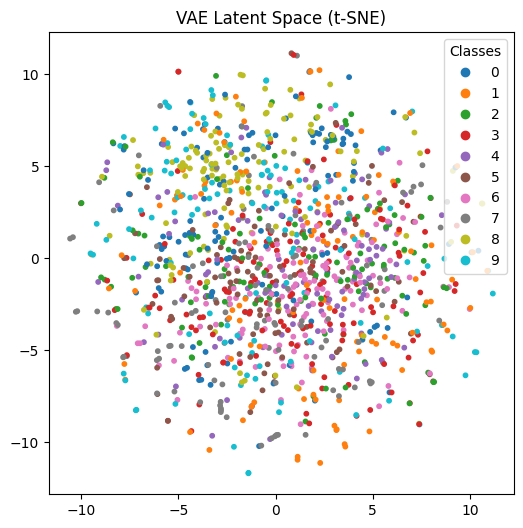

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def interpolate_vae(vae, data_loader, device="cuda", steps=10):
    vae.eval()
    imgs, labels = next(iter(data_loader))
    idx1, idx2 = 0, 1
    img1, img2 = imgs[idx1:idx1+1].to(device), imgs[idx2:idx2+1].to(device)

    with torch.no_grad():
        mu1, logvar1 = vae.encode(img1)
        mu2, logvar2 = vae.encode(img2)
        z1, z2 = mu1, mu2 

        alphas = np.linspace(0, 1, steps)
        interpolations = []
        for a in alphas:
            z = (1-a) * z1 + a * z2
            recon = vae.decode(z)
            interpolations.append(recon.cpu())

    interpolations = torch.cat(interpolations, dim=0)

    fig, axes = plt.subplots(1, steps, figsize=(steps*2, 2))
    for i in range(steps):
        axes[i].imshow(interpolations[i].permute(1,2,0).squeeze().detach().numpy())
        axes[i].axis("off")
        axes[i].set_title(f"α={alphas[i]:.1f}")
    plt.suptitle("VAE Latent Interpolation")
    plt.show()

-
def interpolate_gan(generator, device="cuda", latent_dim=100, steps=10):
    generator.eval()
    z1 = torch.randn(1, latent_dim, device=device)
    z2 = torch.randn(1, latent_dim, device=device)

    alphas = np.linspace(0, 1, steps)
    interpolations = []
    with torch.no_grad():
        for a in alphas:
            z = (1-a) * z1 + a * z2
            gen_img = generator(z)
            interpolations.append(gen_img.cpu())
    interpolations = torch.cat(interpolations, dim=0)

    fig, axes = plt.subplots(1, steps, figsize=(steps*2, 2))
    for i in range(steps):
        axes[i].imshow(interpolations[i].permute(1,2,0).squeeze().detach().numpy())
        axes[i].axis("off")
        axes[i].set_title(f"α={alphas[i]:.1f}")
    plt.suptitle("GAN Latent Interpolation")
    plt.show()


def analyze_vae_latents(vae, data_loader, device="cuda", num_batches=5):
    vae.eval()
    zs, ys = [], []
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(data_loader):
            if i >= num_batches: break
            imgs = imgs.to(device)
            mu, logvar = vae.encode(imgs)
            zs.append(mu.cpu().numpy())
            ys.append(labels.numpy())
    zs = np.concatenate(zs, axis=0)
    ys = np.concatenate(ys, axis=0)

    pca = PCA(n_components=2)
    zs_pca = pca.fit_transform(zs)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    zs_tsne = tsne.fit_transform(zs)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(zs_pca[:,0], zs_pca[:,1], c=ys, cmap="tab10", s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("VAE Latent Space (PCA)")
    plt.show()

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(zs_tsne[:,0], zs_tsne[:,1], c=ys, cmap="tab10", s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("VAE Latent Space (t-SNE)")
    plt.show()


print("Running VAE interpolation...")
interpolate_vae(vae, test_loader, device=device, steps=10)

print("Running GAN interpolation...")
interpolate_gan(generator, device=device, latent_dim=config.gan_latent_dim, steps=10)

print("Analyzing VAE latent representations...")
analyze_vae_latents(vae, test_loader, device=device, num_batches=10)


In [ ]:

def interpolate_vae_with_endpoints(vae, data_loader, device="cuda", steps=10):
    vae.eval()
    imgs, labels = next(iter(data_loader))
    idx1, idx2 = 0, 1
    img1, img2 = imgs[idx1:idx1+1].to(device), imgs[idx2:idx2+1].to(device)

  
    fig, axes = plt.subplots(1, 2, figsize=(4,2))
    axes[0].imshow(img1.squeeze().permute(1,2,0).cpu().numpy())
    axes[0].axis("off")
    axes[0].set_title("Original img1")
    axes[1].imshow(img2.squeeze().permute(1,2,0).cpu().numpy())
    axes[1].axis("off")
    axes[1].set_title("Original img2")
    plt.show()


    with torch.no_grad():
        mu1, logvar1 = vae.encode(img1)
        mu2, logvar2 = vae.encode(img2)
        z1, z2 = mu1, mu2  

        alphas = np.linspace(0, 1, steps)
        interpolations = []
        for a in alphas:
            z = (1-a) * z1 + a * z2
            recon = vae.decode(z)
            interpolations.append(recon.cpu())

    interpolations = torch.cat(interpolations, dim=0)

    fig, axes = plt.subplots(1, steps, figsize=(steps*2, 2))
    for i in range(steps):
        axes[i].imshow(interpolations[i].permute(1,2,0).squeeze().detach().numpy())
        axes[i].axis("off")
        axes[i].set_title(f"α={alphas[i]:.1f}")
    plt.suptitle("VAE Latent Interpolation")
    plt.show()
print("Running VAE interpolation (with endpoints)...")
interpolate_vae_with_endpoints(vae, test_loader, device=device, steps=10)


Analyzing VAE latent representations with UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


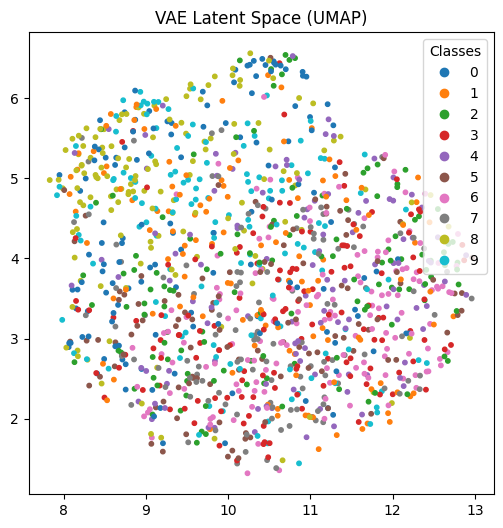

In [ ]:


!pip install umap-learn --quiet

import umap

def analyze_vae_latents_with_umap(vae, data_loader, device="cuda", num_batches=5):
    vae.eval()
    zs, ys = [], []
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(data_loader):
            if i >= num_batches: break
            imgs = imgs.to(device)
            mu, logvar = vae.encode(imgs)
            zs.append(mu.cpu().numpy())
            ys.append(labels.numpy())
    zs = np.concatenate(zs, axis=0)
    ys = np.concatenate(ys, axis=0)

    reducer = umap.UMAP(n_components=2, random_state=42)
    zs_umap = reducer.fit_transform(zs)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(zs_umap[:,0], zs_umap[:,1], c=ys, cmap="tab10", s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("VAE Latent Space (UMAP)")
    plt.show()


print("Analyzing VAE latent representations with UMAP...")
analyze_vae_latents_with_umap(vae, test_loader, device=device, num_batches=10)


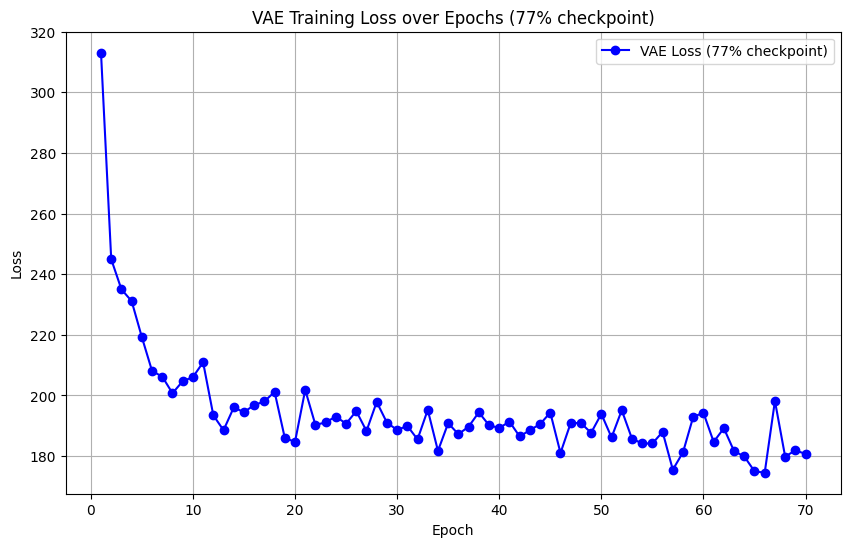

In [ ]:
import matplotlib.pyplot as plt

vae_losses = [
    313.081818, 244.949890, 235.012558, 231.129181, 219.257904,
    208.074310, 206.212280, 200.736771, 204.699234, 206.055008,
    210.933838, 193.448578, 188.537079, 196.030212, 194.488556,
    196.830170, 198.031921, 201.188782, 185.988251, 184.679169,
    201.827286, 190.268890, 191.120087, 193.052567, 190.682678,
    194.833313, 188.259338, 197.868225, 191.039734, 188.608459,
    189.960236, 185.514542, 195.248672, 181.709549, 190.864807,
    187.214569, 189.693970, 194.422485, 190.200073, 189.243042,
    191.382385, 186.477249, 188.552261, 190.528839, 194.361404,
    181.013809, 190.911957, 190.885712, 187.678406, 193.921112,
    186.152206, 195.131378, 185.741333, 184.163391, 184.152206,
    187.986755, 175.498627, 181.258240, 192.954788, 194.270828,
    184.682495, 189.176376, 181.623871, 179.865082, 174.995346,
    174.507141, 198.192062, 179.851379, 181.851608, 180.735916
]

epochs = list(range(1, len(vae_losses)+1))

plt.figure(figsize=(10,6))
plt.plot(epochs, vae_losses, marker='o', linestyle='-', color='blue', label="VAE Loss (77% checkpoint)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss over Epochs (77% checkpoint)")
plt.legend()
plt.grid(True)
plt.show()


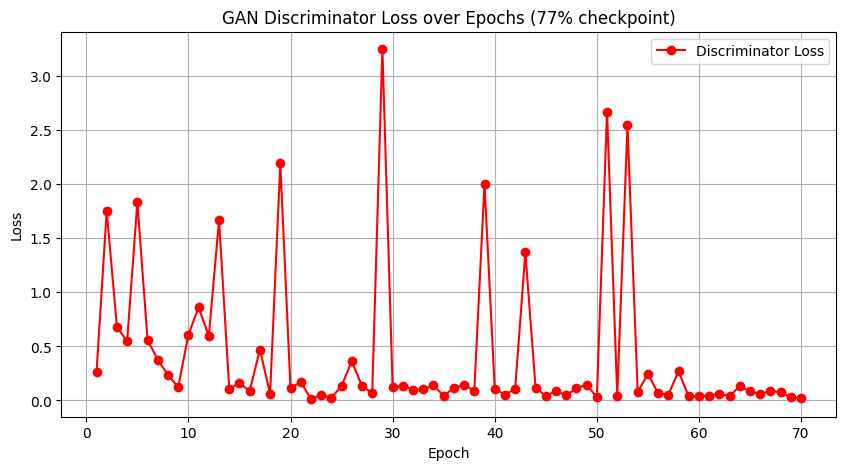

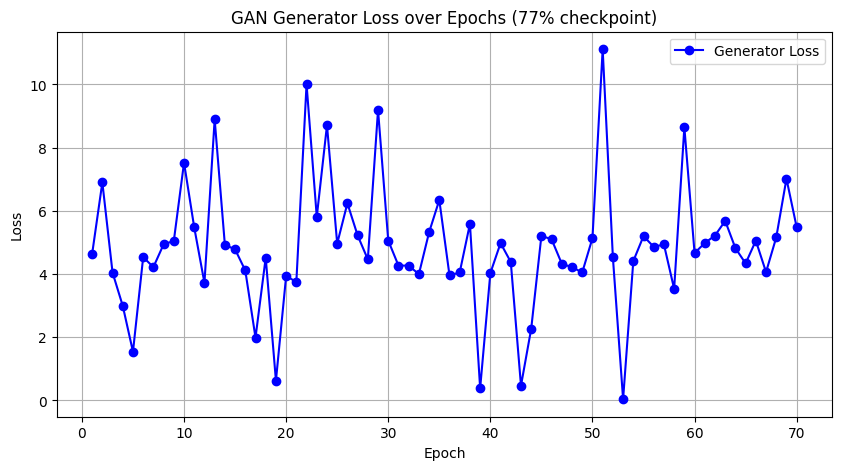

In [ ]:
import matplotlib.pyplot as plt

d_losses = [
    0.259333, 1.751770, 0.678756, 0.548406, 1.835210, 0.558819, 0.376365, 0.234935, 0.122880, 0.607497,
    0.862033, 0.594531, 1.666873, 0.106186, 0.161462, 0.086070, 0.471269, 0.059969, 2.192873, 0.111797,
    0.172832, 0.011220, 0.053386, 0.022522, 0.134574, 0.364008, 0.133303, 0.068253, 3.249586, 0.120898,
    0.135770, 0.098210, 0.103330, 0.138541, 0.043329, 0.115966, 0.143614, 0.091086, 2.004812, 0.109763,
    0.053366, 0.105561, 1.369036, 0.117127, 0.041609, 0.087820, 0.047995, 0.110464, 0.145452, 0.028583,
    2.670793, 0.042206, 2.545186, 0.076617, 0.246052, 0.066713, 0.052363, 0.270531, 0.036607, 0.036645,
    0.044250, 0.063949, 0.037848, 0.133486, 0.083478, 0.060087, 0.088835, 0.075854, 0.030796, 0.018686
]

g_losses = [
    4.636644, 6.900976, 4.046279, 2.992512, 1.542656, 4.533215, 4.220715, 4.939211, 5.048398, 7.525013,
    5.474296, 3.720159, 8.895214, 4.923090, 4.782088, 4.112487, 1.987915, 4.518418, 0.626126, 3.935802,
    3.751551, 10.008392, 5.810479, 8.709252, 4.962678, 6.239778, 5.224405, 4.463480, 9.193634, 5.059930,
    4.269694, 4.266500, 3.997018, 5.320914, 6.342779, 3.957050, 4.052716, 5.587918, 0.380829, 4.030435,
    4.979473, 4.382264, 0.468046, 2.266271, 5.213048, 5.096898, 4.324659, 4.216886, 4.051438, 5.136152,
    11.115405, 4.527817, 0.038592, 4.410087, 5.200212, 4.861691, 4.935518, 3.530276, 8.648000, 4.665173,
    4.980901, 5.219450, 5.682371, 4.819689, 4.336322, 5.056267, 4.061814, 5.160964, 7.016846, 5.481597
]

epochs = list(range(1, len(d_losses)+1))

plt.figure(figsize=(10,5))
plt.plot(epochs, d_losses, marker='o', linestyle='-', color='red', label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Discriminator Loss over Epochs (77% checkpoint)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs, g_losses, marker='o', linestyle='-', color='blue', label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Generator Loss over Epochs (77% checkpoint)")
plt.legend()
plt.grid(True)
plt.show()
